(12, 94, 192)


Text(0.5, 1.0, 'Zonal mean surface temperature (degC)')

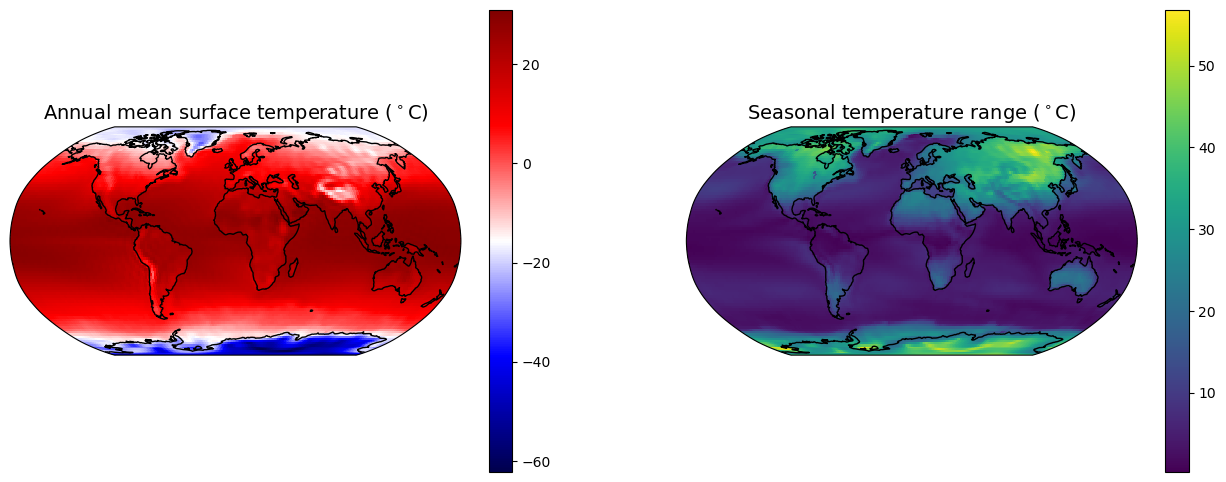

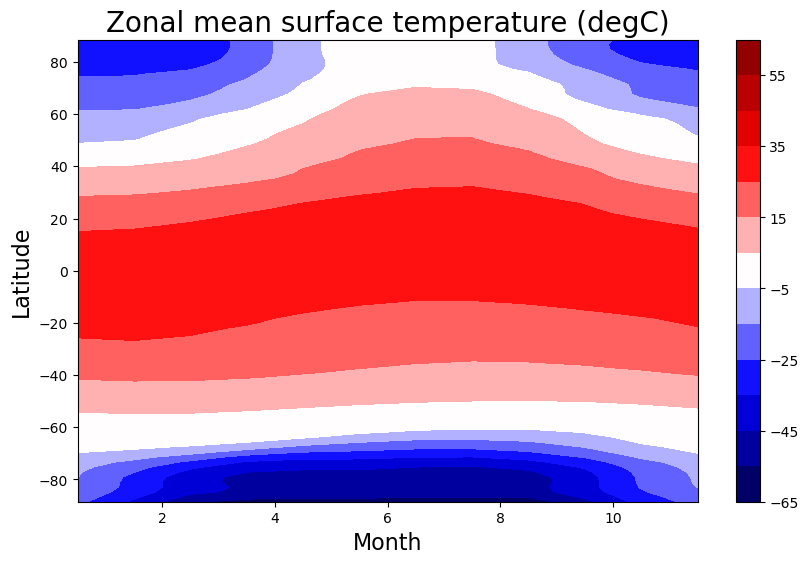

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const
import cartopy.crs as ccrs  # use cartopy to make some maps

ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
#ncep_url = "http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = xr.open_dataset(ncep_url + "skt.sfc.mon.1981-2010.ltm.nc", decode_times=False)
# Alternative source from the University of Hawai'i
#url = "http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/"
#ncep_Ts = xr.open_dataset(url + 'surface_gauss/skt')
lat_ncep = ncep_Ts.lat; lon_ncep = ncep_Ts.lon
Ts_ncep = ncep_Ts.skt
print( Ts_ncep.shape)

maxTs = Ts_ncep.max(dim='time')
minTs = Ts_ncep.min(dim='time')
meanTs = Ts_ncep.mean(dim='time')

fig = plt.figure( figsize=(16,6) )

ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
cax1 = ax1.pcolormesh(lon_ncep, lat_ncep, meanTs, cmap=plt.cm.seismic , transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(cax1)
ax1.set_title('Annual mean surface temperature ($^\circ$C)', fontsize=14 )

ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
cax2 = ax2.pcolormesh(lon_ncep, lat_ncep, maxTs - minTs, transform=ccrs.PlateCarree() )
cbar2 = plt.colorbar(cax2)
ax2.set_title('Seasonal temperature range ($^\circ$C)', fontsize=14)

for ax in [ax1,ax2]:
    #ax.contour( lon_cesm, lat_cesm, topo.variables['LANDFRAC'][:], [0.5], colors='k');
    #ax.set_xlabel('Longitude', fontsize=14 ); ax.set_ylabel('Latitude', fontsize=14 )
    ax.coastlines()

Tmax = 65; Tmin = -Tmax; delT = 10
clevels = np.arange(Tmin,Tmax+delT,delT)
fig_zonobs, ax = plt.subplots( figsize=(10,6) )
cax = ax.contourf(np.arange(12)+0.5, lat_ncep, 
                  Ts_ncep.mean(dim='lon').transpose(), levels=clevels, 
                  cmap=plt.cm.seismic, vmin=Tmin, vmax=Tmax)
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16 )
cbar = plt.colorbar(cax)
ax.set_title('Zonal mean surface temperature (degC)', fontsize=20)


1.991063797294792e-07


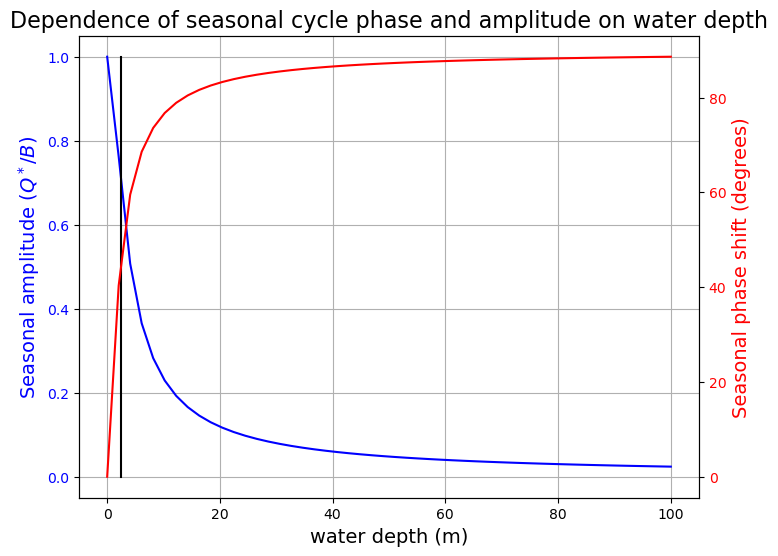

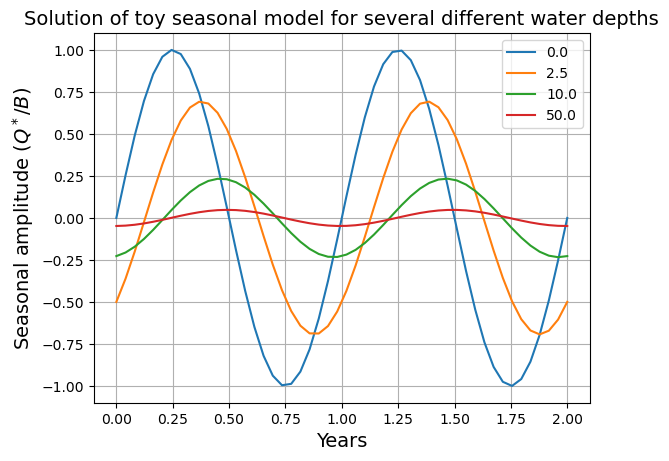

In [2]:
omega = 2*np.pi / const.seconds_per_year
print(omega)

B = 2.
Hw = np.linspace(0., 100.)
Ctilde = const.cw * const.rho_w * Hw * omega / B
amp = 1./((Ctilde**2+1)*np.cos(np.arctan(Ctilde)))
Phi = np.arctan(Ctilde)

color1 = 'b'
color2 = 'r'

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(Hw, amp, color=color1)
ax1.set_xlabel('water depth (m)', fontsize=14)
ax1.set_ylabel('Seasonal amplitude ($Q^* / B$)', fontsize=14,  color=color1)
for tl in ax1.get_yticklabels():
    tl.set_color(color1)
ax2 = ax1.twinx()
ax2.plot(Hw, np.rad2deg(Phi), color=color2)
ax2.set_ylabel('Seasonal phase shift (degrees)', fontsize=14, color=color2)
for tl in ax2.get_yticklabels():
    tl.set_color(color2)
ax1.set_title('Dependence of seasonal cycle phase and amplitude on water depth', fontsize=16)
ax1.grid()

ax1.plot([2.5, 2.5], [0, 1], 'k-');

fig, ax = plt.subplots()
years = np.linspace(0,2)
Harray = np.array([0., 2.5, 10., 50.])
for Hw in Harray:
    Ctilde = const.cw * const.rho_w * Hw * omega / B
    Phi = np.arctan(Ctilde)
    ax.plot(years, np.sin(2*np.pi*years - Phi)/np.cos(Phi)/(1+Ctilde**2), label=Hw)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Seasonal amplitude ($Q^* / B$)', fontsize=14)
ax.set_title('Solution of toy seasonal model for several different water depths', fontsize=14)
ax.legend(); ax.grid()


{'A': 210, 'B': 2, 'a0': 0.354, 'a2': 0.25, 'D': 0.6}
climlab Process of type <class 'climlab.model.ebm.EBM_seasonal'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
The subprocess tree: 
Seasonal EBM: <class 'climlab.model.ebm.EBM_seasonal'>
   LW: <class 'climlab.radiation.aplusbt.AplusBT'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   albedo: <class 'climlab.surface.albedo.P2Albedo'>
   SW: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>
   diffusion: <class 'climlab.dynamics.meridional_heat_diffusion.MeridionalHeatDiffusion'>



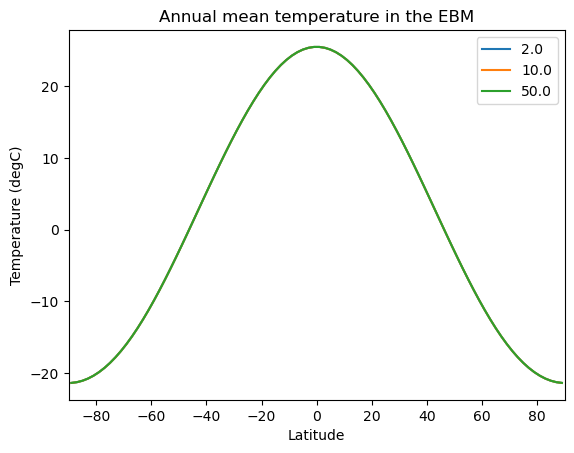

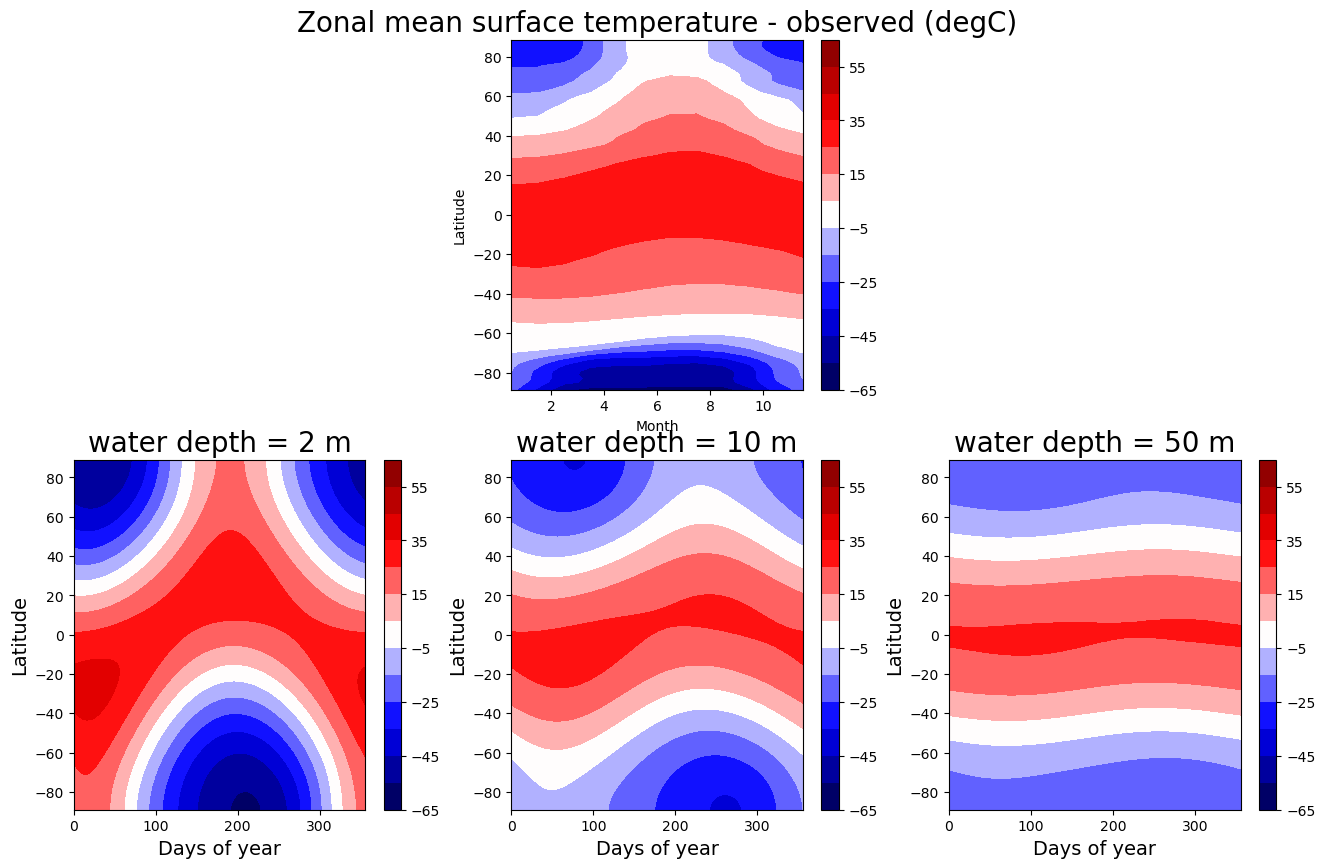

In [3]:
#  for convenience, set up a dictionary with our reference parameters
param = {'A':210, 'B':2, 'a0':0.354, 'a2':0.25, 'D':0.6}
print(param)

#  We can pass the entire dictionary as keyword arguments using the ** notation
model1 = climlab.EBM_seasonal(**param, name='Seasonal EBM')
print(model1)

#  We will try three different water depths
water_depths = np.array([2., 10., 50.])

num_depths = water_depths.size
Tann = np.empty( [model1.lat.size, num_depths] )
models = []

for n in range(num_depths):
    ebm = climlab.EBM_seasonal(water_depth=water_depths[n], **param)
    models.append(ebm)
    models[n].integrate_years(20., verbose=False )
    models[n].integrate_years(1., verbose=False)
    Tann[:,n] = np.squeeze(models[n].timeave['Ts'])

lat = model1.lat
fig, ax = plt.subplots()
ax.plot(lat, Tann)
ax.set_xlim(-90,90)
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature (degC)')
ax.set_title('Annual mean temperature in the EBM')
ax.legend( water_depths )

num_steps_per_year = int(model1.time['num_steps_per_year'])
Tyear = np.empty((lat.size, num_steps_per_year, num_depths))
for n in range(num_depths):
    for m in range(num_steps_per_year):
        models[n].step_forward()
        Tyear[:,m,n] = np.squeeze(models[n].Ts)

fig = plt.figure( figsize=(16,10) )

ax = fig.add_subplot(2,num_depths,2)
cax = ax.contourf(np.arange(12)+0.5, lat_ncep, 
                  Ts_ncep.mean(dim='lon').transpose(), 
                  levels=clevels, cmap=plt.cm.seismic, 
                  vmin=Tmin, vmax=Tmax)
ax.set_xlabel('Month')
ax.set_ylabel('Latitude')
cbar = plt.colorbar(cax)
ax.set_title('Zonal mean surface temperature - observed (degC)', fontsize=20)

for n in range(num_depths):
    ax = fig.add_subplot(2,num_depths,num_depths+n+1)
    cax = ax.contourf(4*np.arange(num_steps_per_year),
                      lat, Tyear[:,:,n], levels=clevels, 
                      cmap=plt.cm.seismic, vmin=Tmin, vmax=Tmax)
    cbar1 = plt.colorbar(cax)
    ax.set_title('water depth = %.0f m' %models[n].param['water_depth'], fontsize=20 )
    ax.set_xlabel('Days of year', fontsize=14 )
    ax.set_ylabel('Latitude', fontsize=14 )


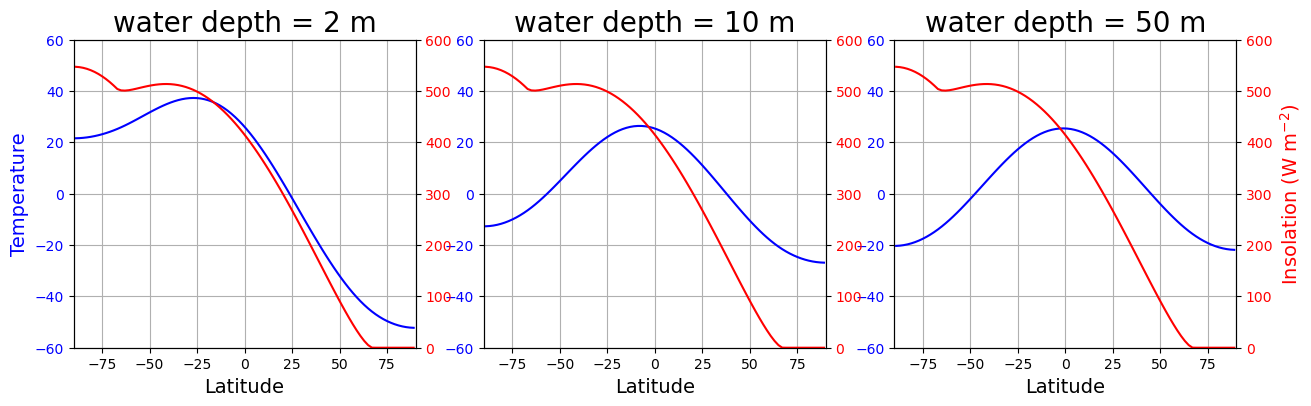

In [4]:
def initial_figure(models):
    fig, axes = plt.subplots(1,len(models), figsize=(15,4))
    lines = []
    for n in range(len(models)):
        ax = axes[n]
        c1 = 'b'
        Tsline = ax.plot(lat, models[n].Ts, c1)[0]
        ax.set_title('water depth = %.0f m' %models[n].param['water_depth'], fontsize=20 )
        ax.set_xlabel('Latitude', fontsize=14 )
        if n == 0:
            ax.set_ylabel('Temperature', fontsize=14, color=c1 )
        ax.set_xlim([-90,90])
        ax.set_ylim([-60,60])
        for tl in ax.get_yticklabels():
            tl.set_color(c1)
        ax.grid()

        c2 = 'r'
        ax2 = ax.twinx()
        Qline = ax2.plot(lat, models[n].insolation, c2)[0]
        if n == 2:
            ax2.set_ylabel('Insolation (W m$^{-2}$)', color=c2, fontsize=14)
        for tl in ax2.get_yticklabels():
            tl.set_color(c2)
        ax2.set_xlim([-90,90])
        ax2.set_ylim([0,600])
        lines.append([Tsline, Qline])
    return fig, axes, lines

def animate(step, models, lines):
    for n, ebm in enumerate(models):
        ebm.step_forward()
        #  The rest of this is just updating the plot
        lines[n][0].set_ydata(ebm.Ts)
        lines[n][1].set_ydata(ebm.insolation)
    return lines

#  Plot initial data
fig, axes, lines = initial_figure(models)

#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

num_steps = int(models[0].time['num_steps_per_year'])
ani = animation.FuncAnimation(fig, animate, 
        frames=num_steps,
        interval=80,
        fargs=(models, lines),
        )

HTML(ani.to_html5_video())


{'ecc': 0.0, 'obliquity': 90.0, 'long_peri': 0.0}
{'ecc': 0.0, 'obliquity': 90.0, 'long_peri': 0.0}


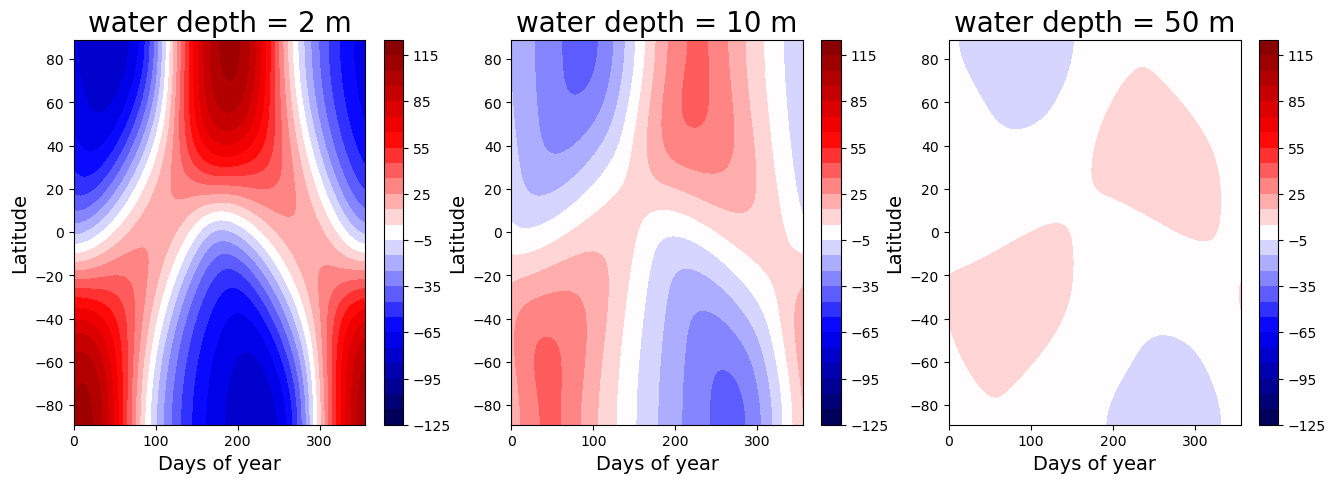

In [5]:
orb_highobl = {'ecc':0., 
               'obliquity':90., 
               'long_peri':0.}
print( orb_highobl)
model_highobl = climlab.EBM_seasonal(orb=orb_highobl, **param)
print( model_highobl.param['orb'])

Tann_highobl = np.empty( [lat.size, num_depths] )
models_highobl = []

for n in range(num_depths):
    model = climlab.EBM_seasonal(water_depth=water_depths[n], 
                                 orb=orb_highobl, 
                                 **param)
    models_highobl.append(model)
    models_highobl[n].integrate_years(40., verbose=False )
    models_highobl[n].integrate_years(1., verbose=False)
    Tann_highobl[:,n] = np.squeeze(models_highobl[n].timeave['Ts'])

Tyear_highobl = np.empty([lat.size, num_steps_per_year, num_depths])
for n in range(num_depths):
    for m in range(num_steps_per_year):
        models_highobl[n].step_forward()
        Tyear_highobl[:,m,n] = np.squeeze(models_highobl[n].Ts)

fig = plt.figure( figsize=(16,5) )
Tmax_highobl = 125; Tmin_highobl = -Tmax_highobl; delT_highobl = 10
clevels_highobl = np.arange(Tmin_highobl, Tmax_highobl+delT_highobl, delT_highobl)
for n in range(num_depths):
    ax = fig.add_subplot(1,num_depths,n+1)
    cax = ax.contourf( 4*np.arange(num_steps_per_year), lat, Tyear_highobl[:,:,n], 
        levels=clevels_highobl, cmap=plt.cm.seismic, vmin=Tmin_highobl, vmax=Tmax_highobl )
    cbar1 = plt.colorbar(cax)
    ax.set_title('water depth = %.0f m' %models[n].param['water_depth'], fontsize=20 )
    ax.set_xlabel('Days of year', fontsize=14 )
    ax.set_ylabel('Latitude', fontsize=14 )

lat2 = np.linspace(-90, 90, 181)
days = np.linspace(1.,50.)/50 * const.days_per_year
Q_present = climlab.solar.insolation.daily_insolation( lat2, days )
Q_highobl = climlab.solar.insolation.daily_insolation( lat2, days, orb_highobl )
Q_present_ann = np.mean( Q_present, axis=1 )
Q_highobl_ann = np.mean( Q_highobl, axis=1 )
